In [2]:
from ray import tune,init
import torch
import argparse
import pandas as pd
import matplotlib.pyplot as plt
import os
import jetnet 
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler

import mplhep as hep
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import FrEIA.framework as Ff
import FrEIA.modules as Fm
import sys
from torch import nn
from torch.optim.lr_scheduler import ExponentialLR
from torch import autograd
from torch.autograd import grad
from  torch.cuda.amp import autocast
import time
from ray.tune.suggest import ConcurrencyLimiter
from ray.tune.suggest.nevergrad import NevergradSearch
from ray.tune.suggest.dragonfly import DragonflySearch
from ray.tune.suggest.bayesopt import BayesOptSearch
from ray.tune.schedulers import HyperBandScheduler,AsyncHyperBandScheduler
import nevergrad as ng
from hist import Hist
plt.style.use(hep.style.ROOT)
#from functools import partial
device='cuda' if torch.cuda.is_available() else 'cpu'

print(device)


cuda


In [262]:
jetnet.datasets.JetNet("t",download=True)

In [257]:

def train(config,jets=None,scaler=None,hyperopt=True):
    limit=-1
    torch.manual_seed(0)
    train,test= train_test_split(jets[-1][:limit] ,test_size=0.3, random_state=42)
    X=torch.Tensor(train)#.to(device)
    dataloader = DataLoader(X, int(config["batch_size"]), shuffle=True)
    n_dim=X.shape[1]
    min_loss=np.inf
    device='cuda' if torch.cuda.is_available() else 'cpu'
    
    def subnet(dims_in, dims_out):
        network=[]
        nodes=int(config["network_nodes"])
        network.append(nn.Linear(dims_in,nodes))
        if config["activation"]=='relu' :
            act=nn.ReLU()
        elif config["activation"]=='lrelu':
            act=nn.LeakyReLU()
        elif config["activation"]=='sigmoid':
            act=nn.Sigmoid()
        elif config["activation"]=='tanh':
            act=nn.Tanh()
        elif config["activation"]<1:
                act=nn.ReLU()
        elif config["activation"]<2:
                act=nn.LeakyReLU()
        ##Commented out because performs badly
        # elif config["activation"]<3:
        #         act=nn.Sigmoid() 
        elif config["activation"]<3:
                act=nn.Tanh()
        
        else:
            print(int(config["activation"]))
            raise CustomError("Unknown activation function")
        network.append(act)

        for k in range(int(config["network_layers"]-1)):
            layer=nn.Linear(nodes,nodes)
            torch.nn.init.xavier_uniform_(layer.weight)
            network.append(layer)
            network.append(act)
        layer=nn.Linear(nodes,dims_out)
        torch.nn.init.zeros_(layer.weight)
        network.append(layer)
        return nn.Sequential(*network)
    

    inn = Ff.SequenceINN(90).to(device)
    for k in range(int(config["coupling_layers"])):  
        inn.append(Fm.AllInOneBlock,  subnet_constructor=subnet,permute_soft=config["permute_soft"],affine_clamping=torch.tensor(1.0))
    inn=inn.to(device)
    best_model=inn
    max_steps=4000
    epochs_no_improve=0
    w1p,w1efp,w1m,mmd,cov="","","","",""
    inn=inn.to(device)
    lgrads=[]
    logprobs=[]
    losses=[]
    w1ps=[]
    w1efps=[]
    w1ms=[]
    covs=[]
    mmds=[]
    loss_corr=[]  
    if  config["opt"]>0.5:
        optimizer = torch.optim.AdamW(inn.parameters(), lr=config["lr"],weight_decay=config["wdecay"])
    elif  config["opt"]<=0.5:
        optimizer = torch.optim.Adam(inn.parameters(), lr=config["lr"])

    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, config["lrdecay"])    
    for step in range(max_steps): 
        losses.append(0)
        lgrads.append(0)
        for id_batch, (x_batch) in enumerate(dataloader):
            optimizer.zero_grad()
            x_batch=x_batch.to(device)
            z, log_jac_det = inn(x_batch)
            # calculate the negative log-likelihood of the model with a standard normal prior
            loss = 0.5*torch.sum(z**2, 1) - log_jac_det
            loss = loss.mean() / n_dim
            if config["wasserstein"]>0.5:
                lgrad=grad_penalty(x_batch)
                loss = loss + config["lambda"]*lgrad
                lgrads[-1]+=lgrad.cpu().detach().numpy()
            # backpropagate and update the weights
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(inn.parameters(), max_norm=1)
            optimizer.step()
            losses[-1] +=float(loss.cpu().detach().numpy())
        scheduler.step()
        losses[-1]=(losses[-1]/(id_batch+1))
        lgrads[-1]=(lgrads[-1]/(id_batch+1))
        if losses[-1] <min_loss:
        # Save the model
            torch.save(inn)
            epochs_no_improve = 0
            min_loss=losses[-1]
            best_model=inn
            
        else:
            epochs_no_improve += 1
            #print("lr lowered, now: {}".format(lr))
        if step > 5 and epochs_no_improve == 25:
            print('Early stopping!')
            early_stop = True
            break
        if step%10==1:
            print('step: {}, loss: {}, '.format(step, losses[-1]))
            # N=int(np.shape(test)[0]/10)
            # print(N)
            
            # gen=scaler.inverse_transform(inn(torch.randn([N,90]).to(device),rev=True)[0].cpu().detach().numpy())
            # indices=[2+3*i for i in range(30)]
            # gen[:,indices]=np.absolute(gen[:,indices])+0.000001
            # true=scaler.inverse_transform(test)
            # true_sample=true[np.random.choice(N)]
            # w1p=np.round(jetnet.evaluation.w1p(gen[:N].reshape((len(gen[:N]),30,3)),
            #     true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]
            # w1m=np.round(jetnet.evaluation.w1m(gen[:N].reshape((len(gen[:N]),30,3)),
            #     true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]
            # w1efp=np.round(jetnet.evaluation.w1efp(gen[:N].reshape((len(gen[:N]),30,3)),
            #     true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]
            
            # # cov,mmd=np.round(jetnet.evaluation.cov_mmd(gen[:N].reshape((len(gen[:N]),30,3)),
            # #         true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)
            # w1ps.append(w1p)
            # w1ms.append(w1m)
            # w1efps.append(w1efp)
            # covs.append(cov)
            # mmds.append(mmd)
            # loss_corr.append(losses[-1])

# N=1
    # N=min(N,len(test))
    if False:
        N=5000
        inn=best_model.to('cpu')
        
        gen=scaler.inverse_transform(inn(torch.randn([N,90]).to('cpu'),rev=True)[0].detach().numpy())
        true=scaler.inverse_transform(test)
        true_sample=true[np.random.choice(N)]
        w1p=np.round(jetnet.evaluation.w1p(gen[:N].reshape((len(gen[:N]),30,3)),
                        true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]
        w1m=np.round(jetnet.evaluation.w1m(gen[:N].reshape((len(gen[:N]),30,3)),
            true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]
        w1efp=np.round(jetnet.evaluation.w1efp(gen[:N].reshape((len(gen[:N]),30,3)),
            true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]
        
        # cov,mmd=np.round(jetnet.evaluation.cov_mmd(gen[:N].reshape((len(gen[:N]),30,3)),
        #                  true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)
        try:
            corr=pd.DataFrame({"loss":loss_corr,"w1m":w1ms,"w1p":w1ps,"w1efp":w1efps
                            ,"mmd":mmds,"cov":covs                   
                            }).corr()
        except:
            print("correlation of metrics didnt work")
    return inn



In [8]:


start=time.time()
best_config = {
    "network_layers": 5,
    "network_nodes":374,
    "lr": 0.004437,
    "activation":1,
    "permute_soft":True,
    "coupling_layers":14,
        "batch_size":4000,
        "lrdecay":0.99,
        "wdecay":0.01,
        "opt":1,
        "lambda":0,
        "affine_clamping":2.0,
        "wasserstein":False
    }

data_dir="/home/kaechben/JetNet_NF/train_t_jets.csv"
limit=100000

data=pd.read_csv(data_dir,sep=" ",header=None)
jets=[]
for njets in range(30,31):
    masks=np.sum(data.values[:,np.arange(3,120,4)],axis=1)
    df=data.loc[masks==njets,:]
    df=df.drop(np.arange(3,120,4),axis=1)
    df=df.iloc[:,:3*njets]

    
    #print("the subsample with {} particles in a jet has {} entries".format(njets,df.shape[0]))
    if len(df)>0:
            jets.append(df.values)
    ###Standard Scaling
for i in [-1]:
    scaler=StandardScaler().fit(jets[i])
    jets[i]=scaler.transform(jets[i][:limit])

inn=train(best_config,jets,scaler,False)
    
print("finished after {} s".format(time.time()-start))
#cur_reserved = torch.cuda.memory_reserved(device)
#cur_alloc = torch.cuda.memory_allocated(device) 
#https://pypi.org/project/nvidia-htop/

step: 1, loss: 0.2512806678811709, 
step: 11, loss: 0.03841085504326555, 
step: 21, loss: -0.005409455392509699, 
step: 31, loss: -0.0401588665942351, 
step: 41, loss: -0.07714481030901273, 
step: 51, loss: -0.11858473511205779, 
step: 61, loss: -0.16919994519816506, 
step: 71, loss: -0.2177327060037189, 
step: 81, loss: -0.26035163220432067, 
step: 91, loss: -0.3045927898751365, 
step: 101, loss: -0.34783350262377, 
step: 111, loss: -0.383302950196796, 
step: 121, loss: -0.4207850744326909, 
step: 131, loss: -0.4566744615634282, 
step: 141, loss: -0.4911692324611876, 
step: 151, loss: -0.5210809773868985, 
step: 161, loss: -0.5494445860385895, 
step: 171, loss: -0.5763151446978251, 
step: 181, loss: -0.606408930487103, 
step: 191, loss: -0.634806944264306, 
step: 201, loss: -0.6629843645625644, 
step: 211, loss: -0.68437393506368, 
step: 221, loss: -0.7076485521263547, 
step: 231, loss: -0.733134925365448, 
step: 241, loss: -0.7567455470561981, 
step: 251, loss: -0.7772516243987613, 


In [106]:
N=30000

# data=pd.read_csv(data_dir,sep=" ",header=None)
jets=[]
for njets in range(30,31):
    masks=np.sum(data.values[:,np.arange(3,120,4)],axis=1)
    df=data.loc[masks==njets,:]
    df=df.drop(np.arange(3,120,4),axis=1)
    df=df.iloc[:,:3*njets]

    
    #print("the subsample with {} particles in a jet has {} entries".format(njets,df.shape[0]))
    if len(df)>0:
            jets.append(df.values)
    ###Standard Scaling
for i in [-1]:
    scaler=StandardScaler().fit(jets[i])
    jets[i]=scaler.transform(jets[i][:limit])

train,test= train_test_split(jets[-1][:limit] ,test_size=0.3, random_state=42)
inn=inn.to("cpu")
gen=scaler.inverse_transform(inn(torch.randn([N,90]).to('cpu'),rev=True)[0].detach().numpy())
true=scaler.inverse_transform(test[:N])
true_sample=true[np.random.choice(N)]
w1p=np.round(jetnet.evaluation.w1p(gen[:N].reshape((len(gen[:N]),30,3)),
                true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]
w1m=np.round(jetnet.evaluation.w1m(gen[:N].reshape((len(gen[:N]),30,3)),
    true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]
w1efp=np.round(jetnet.evaluation.w1efp(gen[:N].reshape((len(gen[:N]),30,3)),
    true[:N].reshape((len(true[:N]),30,3)),num_batches=20),5)[0]

(array([1.40000e+02, 9.51910e+04, 2.81650e+05, 1.63678e+05, 9.56290e+04,
        6.19620e+04, 4.28300e+04, 3.06930e+04, 2.29590e+04, 1.78340e+04,
        1.41940e+04, 1.14030e+04, 9.15200e+03, 7.59500e+03, 6.24600e+03,
        5.21000e+03, 4.20800e+03, 3.81900e+03, 3.26100e+03, 2.84600e+03,
        2.44800e+03, 2.13800e+03, 1.83900e+03, 1.57600e+03, 1.35200e+03,
        1.15300e+03, 1.11600e+03, 8.55000e+02, 7.77000e+02, 6.21000e+02,
        6.09000e+02, 5.14000e+02, 4.95000e+02, 4.55000e+02, 3.70000e+02,
        3.37000e+02, 2.72000e+02, 2.50000e+02, 2.37000e+02, 1.96000e+02,
        1.62000e+02, 1.61000e+02, 1.50000e+02, 1.17000e+02, 1.28000e+02,
        1.16000e+02, 9.80000e+01, 9.60000e+01, 7.80000e+01, 7.70000e+01,
        6.60000e+01, 6.10000e+01, 5.70000e+01, 4.20000e+01, 4.90000e+01,
        4.60000e+01, 4.10000e+01, 4.00000e+01, 2.10000e+01, 2.60000e+01,
        2.60000e+01, 2.80000e+01, 2.90000e+01, 2.60000e+01, 1.70000e+01,
        1.10000e+01, 6.00000e+00, 1.50000e+01, 1.70

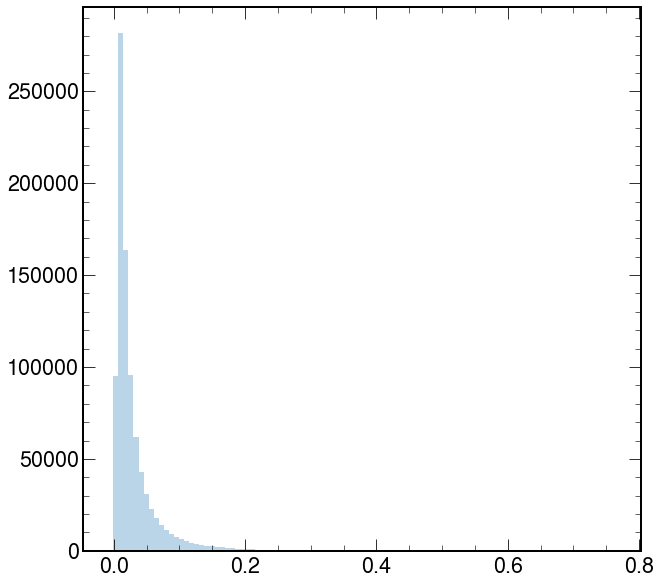

In [245]:
# fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
# hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
# main_ax_artists, sublot_ax_arists = h.plot_ratio(
#     h2,
#     ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
#     rp_ylabel=r"Ratio",
#     rp_num_label="Generated",
#     rp_denom_label="Data",
#     rp_uncert_draw_type="line",  # line or bar
# )
# ax[0].set_xlabel("")
# ax[0].set_yscale("log")
# plt.xlabel(r"E/$p_T^{jet}$ [A.U.]")
# plt.savefig("jetnet_hists/energy.png")
# plt.show()
    
# plt.hist(data[:len(gen)].values.reshape(len(gen)*30,4)[:,1],bins=100,alpha=0.3)
plt.hist(gen.reshape(len(gen)*30,3)[:,2],bins=100,alpha=0.3)

(array([3.600e+01, 2.330e+02, 7.750e+02, 1.669e+03, 2.548e+03, 2.944e+03,
        3.030e+03, 2.833e+03, 2.482e+03, 2.207e+03, 1.826e+03, 1.527e+03,
        1.245e+03, 1.116e+03, 8.510e+02, 7.250e+02, 5.860e+02, 4.980e+02,
        3.810e+02, 3.300e+02, 2.810e+02, 2.240e+02, 2.090e+02, 1.870e+02,
        1.240e+02, 1.490e+02, 1.360e+02, 8.600e+01, 8.300e+01, 7.300e+01,
        4.600e+01, 5.600e+01, 5.100e+01, 5.300e+01, 3.700e+01, 2.500e+01,
        3.600e+01, 3.100e+01, 2.000e+01, 3.100e+01, 2.600e+01, 2.100e+01,
        1.700e+01, 1.300e+01, 9.000e+00, 1.100e+01, 1.500e+01, 9.000e+00,
        1.200e+01, 1.000e+01, 9.000e+00, 7.000e+00, 1.000e+00, 6.000e+00,
        6.000e+00, 8.000e+00, 4.000e+00, 3.000e+00, 3.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+0

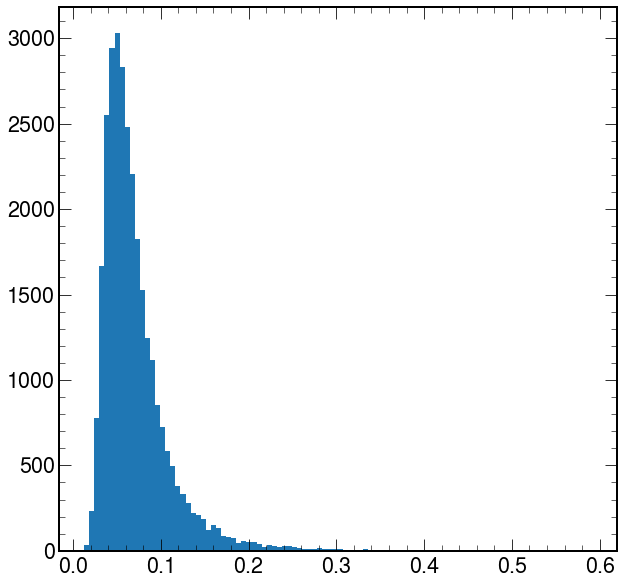

In [227]:
a=np.zeros_like(gen[:,3])
for i in range(30):
    a+=(np.cos(gen[:,3*i])*gen[:,3*i+2])**2+(np.sin(gen[:,3*i])*gen[:,3*i+2])**2
plt.hist(a,bins=100)

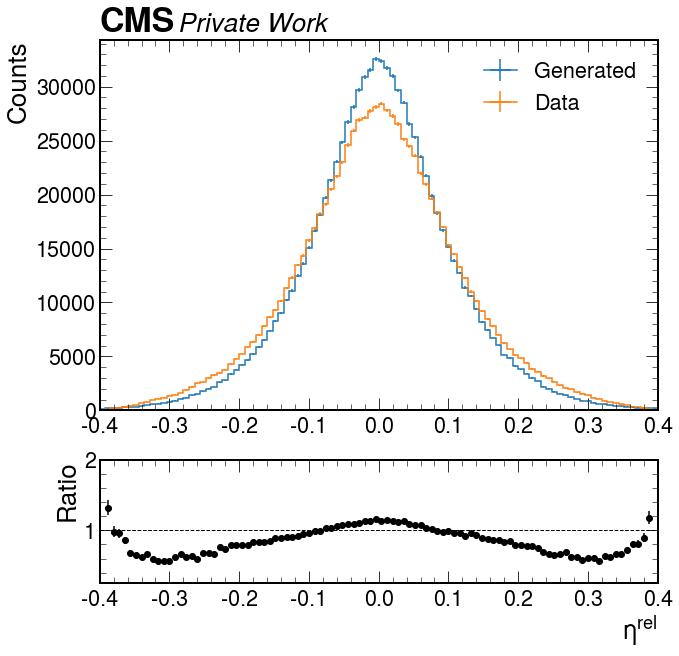

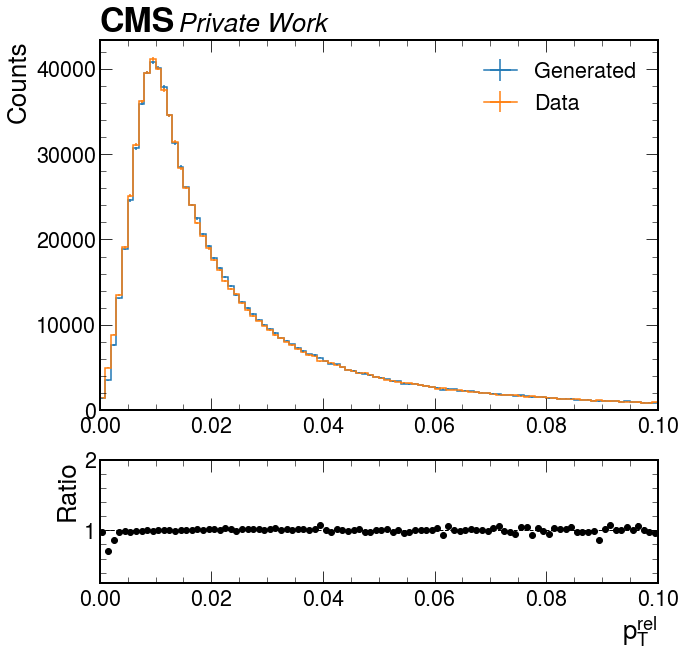

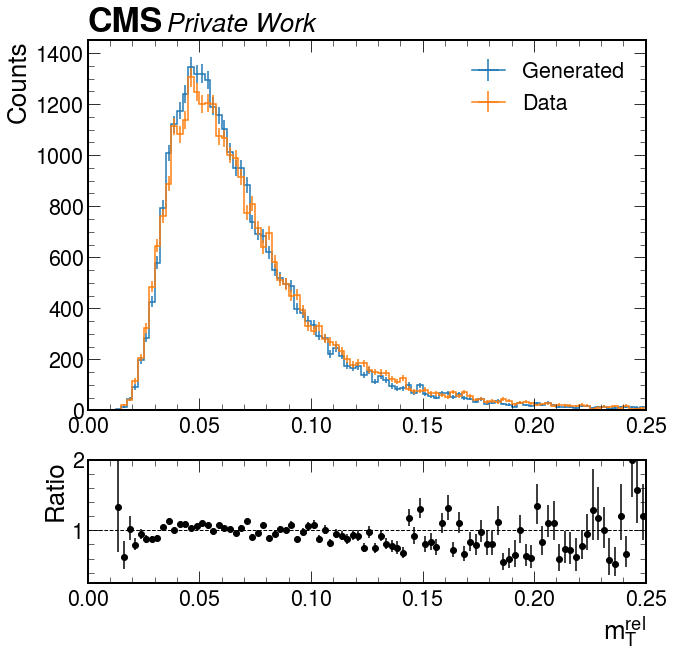

In [254]:
import hist
import vector
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import hist
from hist import Hist
import ctypes
from optparse import OptionParser
import inspect
plt.style.use(hep.style.ROOT)



for v,name in zip(["eta","pt","m"],[r"$\eta^{rel}$",r"$p_T^{rel}$",r"$m_T^{rel}$"]):
    v_sum=vector.array({"pt":np.zeros(len(gen)),"phi":np.zeros(len(gen)),"eta":np.zeros(len(gen)),"M":np.zeros(len(gen))})
    v2_sum=vector.array({"pt":np.zeros(len(gen)),"phi":np.zeros(len(gen)),"eta":np.zeros(len(gen)),"M":np.zeros(len(gen))})

    if v=="pt":
        a=0
        b=0.1
    if v=="eta":
        a=-0.4
        b=0.4
    if  v=="m":
        a=0
        b=0.25
    
    h=hist.Hist(hist.axis.Regular(100,a,b))
    h2=hist.Hist(hist.axis.Regular(100,a,b))
   
    if v=="m":
        m=np.zeros_like(gen[:,0])
        m_t=np.zeros_like(gen[:,0])
        for i in range(30):
            m+=(np.cos(gen[:,3*i])*gen[:,3*i+2])**2+(np.sin(gen[:,3*i])*gen[:,3*i+2])**2
            m_t+=(np.cos(true[:,3*i])*true[:,3*i+2])**2+(np.sin(true[:,3*i])*true[:,3*i+2])**2
        h.fill(m)
        h2.fill(m_t)
    if v=="eta": 

        h.fill(torch.tensor(gen).reshape(len(gen)*30,3).numpy()[:,1])
        h2.fill(torch.tensor(true).reshape(len(gen)*30,3).numpy()[:,1])
    if v=="pt":    
        
        h.fill(torch.tensor(gen).reshape(len(gen)*30,3).numpy()[:,2])
        h2.fill(torch.tensor(true).reshape(len(true)*30,3).numpy()[:,2])
        
   

    fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
    hep.cms.label(data=False,lumi=None ,year=None,rlabel="",llabel="Private Work",ax=ax[0] )
    main_ax_artists, sublot_ax_arists = h.plot_ratio(
        h2,
        ax_dict={"main_ax":ax[0],"ratio_ax":ax[1]},
        rp_ylabel=r"Ratio",
        rp_num_label="Generated",
        rp_denom_label="Data",
        rp_uncert_draw_type="line",  # line or bar
    )
    ax[0].set_xlabel("")
    ax[1].set_ylim(0.25,2)
    ax[0].set_xlim(a,b)
    ax[1].set_xlim(a,b)
    plt.xlabel(name)
    plt.savefig("jetnet_hists/{}.png".format(name))
    plt.show()
    
    # plt.ylim(0.5,2)
    # plt.tight_layout()

In [265]:
inn.state_dict()

OrderedDict([('module_list.0.global_scale',
              tensor([[ 8.4796,  8.7871, 10.3583,  8.3893,  8.4791, 10.1629,  8.1893,  8.1730,
                       10.0859,  8.0121,  7.9651, 10.1007,  8.2898,  7.7366, 10.4138,  8.2076,
                        8.2510, 10.3214,  7.7199,  8.2547, 10.3594,  8.0041,  7.9699, 10.4537,
                        8.0504,  7.6756, 10.4481,  7.7928,  8.0479, 10.6140,  7.8566,  8.1062,
                       10.6781,  7.9167,  7.8634, 10.4241,  8.0430,  7.9568, 10.7581,  7.7841,
                        7.7131, 10.1728,  7.9820,  7.5623, 10.3465,  9.0575,  9.1142, 10.1844,
                        8.9294,  9.1134,  9.9864,  9.0586,  9.1760, 10.0918,  9.0913,  8.9598,
                        9.8888,  9.1071,  9.0626, 10.1847,  9.0829,  9.0564, 10.1343,  8.9709,
                        8.9874, 10.0535,  9.1398,  9.1206, 10.0934,  9.0261,  8.9593,  9.9551,
                        8.8742,  9.0137, 10.1405,  8.9419,  8.9862, 10.1547,  9.0489,  8.8887,
      

In [258]:
import pickle
with open("test.pickle","wb") as f:
    pickle.dump(inn,f)


AttributeError: Can't pickle local object 'AllInOneBlock.__init__.<locals>.<lambda>'

(array([3.000e+00, 3.500e+01, 1.140e+02, 4.740e+02, 1.393e+03, 3.005e+03,
        5.672e+03, 8.424e+03, 8.910e+03, 1.970e+03]),
 array([0.55857592, 0.60644442, 0.65431293, 0.70218144, 0.75004994,
        0.79791845, 0.84578696, 0.89365546, 0.94152397, 0.98939247,
        1.03726098]),
 <BarContainer object of 10 artists>)

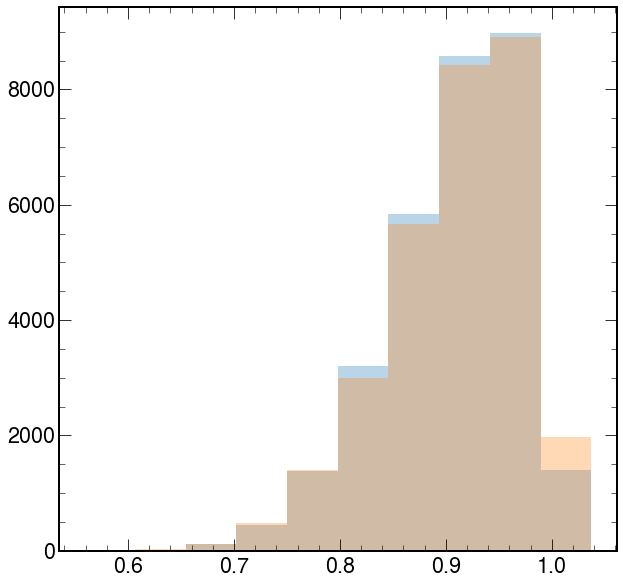

In [116]:
import mplhep as hep
_,bins,_=plt.hist(v_sum.E,alpha=.3)
plt.hist(v2_sum.E,alpha=.3,bins=bins)

# plt.style.use(hep.style.ROOT)
# var=["eta", "phi", "pt"]
# for i in range(90):
#     fig,ax=plt.subplots(2,1,gridspec_kw={'height_ratios': [3, 1]})
#     h=Hist(30,min(gen[:,i]),max(gen[i,:]))
#     h.fill(gen[:,i])
#     h2=Hist(30,min(gen[:,i]),max(gen[i,:]))
#     h2.fill(true[:,i])
    
#     ax[0].bar(bincenters, y/np.sum(y), width=width, color='r', yerr=menStd/np.sum(y),label='truth',fill=None, edgecolor='blue',ecolor='blue'    )
#     ax[0].bar(bincenters, y2/np.sum(y2), width=width, color='b', yerr=menStd2/np.sum(y2),label='gen',fill=None, edgecolor='red',ecolor='red')
#     ratio=y.astype(float)/(y2.astype(float))
#     ratio_err=np.sqrt((menStd/y)**2+(menStd2/y2)**2)
#     ax[0].set_yscale('log')
#     ax[0].legend()
#     ax[1].errorbar(bincenters,ratio,yerr=ratio_err,fmt="+")
#     ax[1].set_ylim(0,2)
#     ax[1].hlines(1,bincenters[0],bincenters[-1],alpha=0.5,color="black",linestyle='dashed')
#     # n,bins,_=plt.hist(,bins=30,density=1,histtype='step',label="true")
#     # plt.hist(gen[:10000,i],bins,density=1,histtype='step',label="generated")
#     ax[0].set_title("jet {}, variable {}".format(int(i/3),var[i%3]))
   
#     plt.ylabel("counts [A.U.]")
#     plt.xlabel(var[int(i%3/3)])
#     plt.show()

### Due to the large improportion, only the sample with 30 particles per jet is used

In [263]:
data=pd.read_csv("q_jets.csv",sep=" ",header=None)
print("data shape: ",data.shape)
jets=[]
for njets in range(5,31):
    masks=np.sum(data.values[:,np.arange(3,120,4)],axis=1)
    df=data.loc[masks==njets,:]
    df=df.drop(np.arange(3,120,4),axis=1)
    df=df.iloc[:,:3*njets]
    df=df
    print("the subsample with {} particles in a jet has {} entries".format(njets,df.shape[0]))
    if len(df)>0:
            jets.append(df.values)
    ###Standard Scaling
for i in [-1]:
    scaler=StandardScaler().fit(jets[i])
    jets[i]=scaler.transform(jets[i])
    #jets[i]= MinMaxScaler().fit_transform(jets[i])
    #

data shape:  (170679, 120)
the subsample with 5 particles in a jet has 1 entries
the subsample with 6 particles in a jet has 5 entries
the subsample with 7 particles in a jet has 31 entries
the subsample with 8 particles in a jet has 44 entries
the subsample with 9 particles in a jet has 100 entries
the subsample with 10 particles in a jet has 184 entries
the subsample with 11 particles in a jet has 288 entries
the subsample with 12 particles in a jet has 503 entries
the subsample with 13 particles in a jet has 671 entries
the subsample with 14 particles in a jet has 1031 entries
the subsample with 15 particles in a jet has 1488 entries
the subsample with 16 particles in a jet has 1928 entries
the subsample with 17 particles in a jet has 2334 entries
the subsample with 18 particles in a jet has 2741 entries
the subsample with 19 particles in a jet has 3322 entries
the subsample with 20 particles in a jet has 3646 entries
the subsample with 21 particles in a jet has 4053 entries
the sub

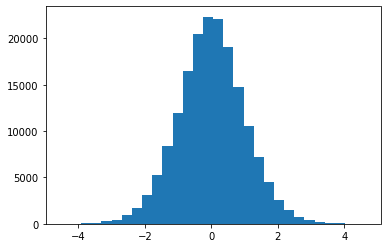

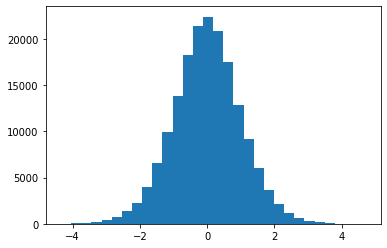

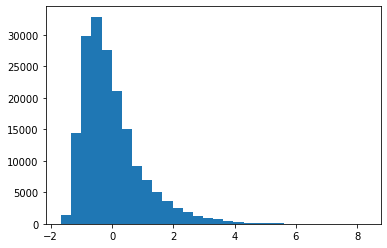

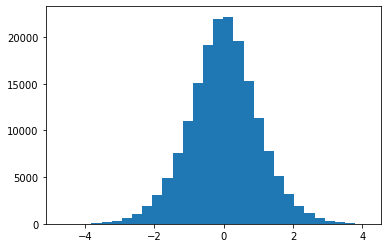

In [4]:
s=jets[-1]
for i in range(4):
    plt.hist(s[:,i],bins=30)
    plt.show()

In [13]:
from sklearn.model_selection import train_test_split

def grad_penalty(real_data):
    batch_size = real_data.size(0)
    fake_data,_ = inn(torch.randn(batch_size,90).to(device))
    # Sample Epsilon from uniform distribution
    eps = torch.rand(batch_size, 90).to(device)
    # eps = eps.expand_as(real_data)
    
    # Interpolation between real data and fake data.
    interpolation = eps * real_data + (1 - eps) * fake_data

    # get logits for interpolated images
    interp_logits,_ = inn(interpolation)
    grad_outputs = torch.ones_like(interp_logits)
    
    # Compute Gradients
    gradients = autograd.grad(
        outputs=interp_logits,
        inputs=interpolation,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]
    
    # Compute and return Gradient Norm
    gr = gradients.view(  batch_size, -1)
    
    gradient_penalty = torch.mean((1. - torch.sqrt(1e-8+torch.sum(gr.view(gr.size(0), -1)**2, dim=1)))**2)
    return gradient_penalty
def subnet(dims_in, dims_out):
    network=[]
    nodes=400
    network.append(nn.Linear(dims_in,nodes))
    
    act=nn.LeakyReLU()
    
    network.append(act)

    for k in range(int(3-1)):
        layer=nn.Linear(nodes,nodes)
        torch.nn.init.xavier_uniform_(layer.weight)
        network.append(layer)
        network.append(act)
    layer=nn.Linear(nodes,dims_out)
    torch.nn.init.zeros_(layer.weight)
    network.append(layer)
    return nn.Sequential(*network)
from torch import autograd
import torch
torch.cuda.empty_cache()
inn = Ff.SequenceINN(90)
wasserstein=True
lamb=1e-2
hyperopt=True


limit=-1
def subnet(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 256), nn.ReLU(),
                         nn.Linear(256, dims_out))
in1 = Ff.InputNode(90, name='Input 1')
perm = Ff.Node(in1, Fm.PermuteRandom, {}, name='Permutation')
actnorm = Ff.Node(perm, Fm.ActNorm, {}, name='ActNorm')
affine = Ff.Node(actnorm, Fm.GaussianMixtureModel, {'subnet_constructor': subnet},
                 conditions=cond, name='Affine Coupling')

output1 = Ff.OutputNode(affine, name='Output 1')
# output2 = Ff.OutputNode(concat2, name='Output 2')

example_INN = Ff.GraphINN([in1,perm,actnorm,output1])
example_INN
# for k in range(6):
    

#     inn.append(Fm.AllInOneBlock,  subnet_constructor=subnet,permute_soft=False)
inn=inn.to(device)
#print(inn.state_dict())
# define inputs
z=0
torch.manual_seed(0)
train,test= train_test_split(jets[-1][:-1] ,test_size=0.3, random_state=42)
X=torch.Tensor(train)#.to(device)
dataloader = DataLoader(X, 1000, shuffle=True)
n_dim=X.shape[1]
min_loss=np.inf
losses=[]
max_steps=4000

epochs_no_improve=0
best_model=inn
inn=inn.to(device)
lgrads=[]
logprobs=[]

    
optimizer = torch.optim.AdamW(inn.parameters(), lr=0.0001,weight_decay=0.99)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.01)

for step in range(max_steps): 
    losses.append(0)
    lgrads.append(0)
    for id_batch, (x_batch) in enumerate(dataloader):
        optimizer.zero_grad()
        x_batch=x_batch.to(device)

        z, log_jac_det = inn(x_batch)
        # calculate the negative log-likelihood of the model with a standard normal prior
        loss = 0.5*torch.sum(z**2, 1) - log_jac_det
        loss = loss.mean() / n_dim
        if wasserstein:
            lgrad=grad_penalty(x_batch)
            loss = loss + lamb*lgrad
            lgrads[-1]+=lgrad.cpu().detach().numpy()
        #print(loss)
        # backpropagate and update the weights
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(inn.parameters(), max_norm=1)
        optimizer.step()
        losses[-1] +=float(loss.cpu().detach().numpy())
        #print(loss)


    scheduler.step()
    losses[-1]=(losses[-1]/(id_batch+1))
    lgrads[-1]=(lgrads[-1]/(id_batch+1))

    if losses[-1] <min_loss:
    # Save the model
        #torch.save(inn,'best_model.pt')
        epochs_no_improve = 0
        min_loss=losses[-1]
        best_model=inn
        
    else:
        epochs_no_improve += 1
        #print("lr lowered, now: {}".format(lr))
    if step > 5 and epochs_no_improve == 25:
        print('Early stopping!')
        early_stop = True
        break
    if step%10==1:
        print('step: {}, loss: {}, '.format(step, losses[-1]))
    


ValueError: optimizer got an empty parameter list

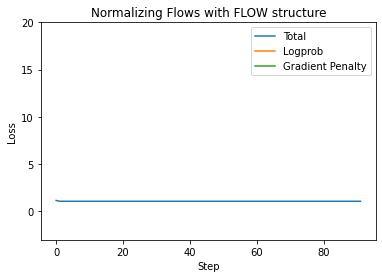

In [12]:


plt.plot(losses,label='Total')
plt.plot(logprobs,label='Logprob')
plt.plot(lgrads,label='Gradient Penalty')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.ylim(-3,20)

plt.legend()
plt.title('Normalizing Flows with FLOW structure')
plt.show()
# x=jets[-1]
# best_model=best_model.cpu()
# permuted_sample=np.zeros_like(x)
# for j in range(np.shape(x)[1]):
#     permuted_sample[:,j]+=x[np.random.permutation(len(x)),j]
# z, log_jac_det = best_model(torch.Tensor(x))
# z_perm, log_jac_det_perm = best_model(torch.Tensor(permuted_sample))
# calculate the negative log-likelihood of the model with a standard normal prior
# loss = 0.5*torch.sum(z**2, 1) - log_jac_det
# loss_perm = 0.5*torch.sum(z_perm**2, 1) - log_jac_det_perm
# print("Original: ", loss.mean().cpu().detach().numpy())
# print("permuted: ", loss_perm.mean().cpu().detach().numpy())
# gen_inv=best_model(best_model(torch.randn([100000,90]),rev=True)[0])[0].cpu().detach().numpy()
# gen_inv=gen_inv.reshape((len(gen_inv),30,3))

# true_inv=best_model.cpu()(X)[0].detach().numpy()
# variables=[r'f($p_T$)',r'f($\eta$)',r'f($\rho$)']
# for col in range(3):
#     plt.figure()
#     plt.title('Normalizing Flow Direction')
#     bins=np.linspace(-5,5,100)
#     plt.hist(gen_inv[:,0,col],label='Generated',alpha=0.5,bins=bins,density=1)
#     plt.hist(z_perm[:,col].cpu().detach().numpy(),label='Permuted',alpha=0.5,bins=bins,density=1)
#     plt.hist(true_inv[:,col],label='True',alpha=0.5,bins=bins,density=1)
#     plt.ylabel('Counts Normalized')
#     plt.xlabel(variables[col])
#     plt.legend()
#     plt.show()



<IPython.core.display.Math object>

<IPython.core.display.Math object>

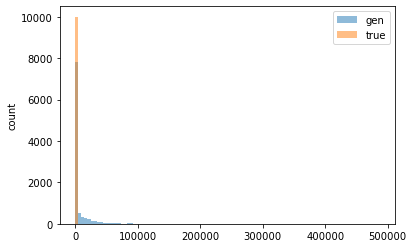

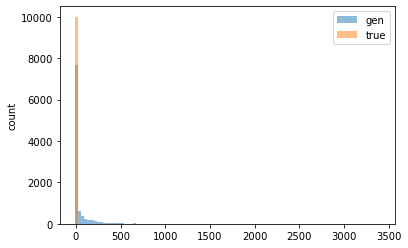

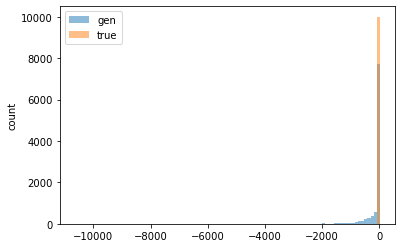

In [20]:
from IPython.display import display, Math
def chi(x_raw,y_raw,bins_count=30):
    
    chi=0
    for i in range(int(np.shape(x_raw)[1]/3)):
        x,bins=np.histogramdd(x_raw[:,i*3:(i+1)*3],bins_count,normed=True)
        y,_=np.histogramdd(y_raw[:,i*3:(i+1)*3],bins,normed=True)
        chi+=np.sum((x-y)**2/np.maximum(x+y,np.ones_like(x)))
    return chi
N=10000
inn=best_model.to('cpu')
gen=(inn(torch.randn([N,90]),rev=True)[0].detach().numpy())
true=(jets[-1][:N])

true_sample=true[np.random.choice(N)]
w1=np.round(jetnet.evaluation.w1p(gen[:N].reshape((len(gen[:N]),30,3)),true[:N].reshape((len(true[:N]),30,3)),num_batches=20),3)
#w1=np.round(jetnet.evaluation.w1p(gen_e[:N].reshape((len(gen_e[:N]),30,3)),true[:N].reshape((len(true[:N]),30,3)),num_batches=20),3)
display(Math(" W_1: {} \pm {}".format(w1[0],w1[1])))
display(Math(r'\chi^2 : {}'.format(np.round(chi(gen[:N],true[:N]),4))))
#display(Math(r'ensemble \chi^2 : {}'.format(np.round(chi(gen_e[:N],true[:N]),4))))

for col in range(3):
    plt.figure()
    n,bins,_=plt.hist(gen[:,col],label='gen',alpha=0.5,bins=100)
    plt.hist(true[:,col],label='true',alpha=0.5,bins=bins)

    
    #plt.hist(gen_e[:,col],label='gen_e',alpha=0.5,bins=bins)
    plt.ylabel('count')
    plt.legend()
    plt.show() 


## 

In [4]:
best_model

NameError: name 'best_model' is not defined

In [126]:
import torch
import torch.nn as nn 
from math import pi 

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal

from __future__ import division

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from math import pi 

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import LogisticNormal



class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.Sigmoid(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.Sigmoid(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 
        if flip:
            x2, x1 = x1, x2
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1,x2 * torch.exp(sig) + self.mu_net(x1)
        if flip:
            z2, z1 = z1, z2
        z_hat = torch.cat([z1, z2], dim=-1)
        log_pz = base_dist.log_prob(z_hat.to(device))
        log_jacob = sig.sum(-1)
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
   
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)
class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        modules=[]
        for _ in range(n):
            modules.append(R_NVP(d,k,hidden=hidden))
            if n!=n-1:
                modules.append(BatchNormFlow(90))
        self.bijectors = nn.ModuleList(modules)
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []
        
        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
class BatchNormFlow(nn.Module):
    """ An implementation of a batch normalization layer from
    Density estimation using Real NVP
    (https://arxiv.org/abs/1605.08803).
    """

    def __init__(self, num_inputs, momentum=0.0, eps=1e-5):
        super(BatchNormFlow, self).__init__()

        self.log_gamma = nn.Parameter(torch.zeros(num_inputs))
        self.beta = nn.Parameter(torch.zeros(num_inputs))
        self.momentum = momentum
        self.eps = eps

        self.register_buffer('running_mean', torch.zeros(num_inputs))
        self.register_buffer('running_var', torch.ones(num_inputs))

    def forward(self, inputs,flip=True, mode='direct'):
        cond_inputs=None
        if mode == 'direct':
            if self.training:
                self.batch_mean = inputs.mean(0)
                self.batch_var = (
                    inputs - self.batch_mean).pow(2).mean(0) + self.eps

                self.running_mean.mul_(self.momentum)
                self.running_var.mul_(self.momentum)
                self.running_mean.add_(self.batch_mean.data * (1 - self.momentum))
                self.running_var.add_(self.batch_var.data * (1 - self.momentum))

                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - mean) / var.sqrt()
            z_hat = torch.exp(self.log_gamma) * x_hat + self.beta
            log_pz = base_dist.log_prob(z_hat.to(device))
            return z_hat, log_pz,(self.log_gamma - 0.5 * torch.log(var)).sum(
                -1)
        else:
            if True:
                mean = self.batch_mean
                var = self.batch_var
            else:
                mean = self.running_mean
                var = self.running_var

            x_hat = (inputs - self.beta) / torch.exp(self.log_gamma)

            y = x_hat * var.sqrt() + mean

            return y, (-self.log_gamma + 0.5 * torch.log(var)).sum(
                -1, keepdim=True)


def train(dataloader,model, epochs,  optim, scheduler):
    losses = []
    for _ in range(epochs):
        losses.append(0)
        # get batch 
        for idx,x_batch in enumerate(dataloader):
            optim.zero_grad()
            model=model.to(device)      
            z, log_pz, log_jacob = model(x_batch.to(device))
            loss = (-log_pz - log_jacob).mean()
            loss.backward()
            optim.step()
            
            losses[-1]+=loss.cpu().detach().numpy()
        losses[-1]/=(idx+1)
        if _%100==1:
            print("Epoch {} loss: {}".format(_,loss))
        
        scheduler.step()
    return losses
def view(dataloader,model, losses):
    plt.plot(losses)
    plt.title("Model Loss vs Epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    X_hat = model.inverse(Z).cpu().detach().numpy()
    plt.scatter(X_hat[:, 0], X_hat[:, 1])
    plt.title("Inverse of Normal Samples Z: X = F^-1(Z)")
    plt.show()

    n_samples = 3000
    z, _, _ = model(X.to(device))
    z = z.cpu().detach().numpy()
    plt.scatter(z[:, 0], z[:, 1])
    plt.title("Transformation of Data Samples X: Z = F(X)")
    plt.show()


d = 90
k = 45


Epoch 1 loss: 137.88473510742188
Epoch 101 loss: 89.56378173828125
Epoch 201 loss: 67.17134857177734
Epoch 301 loss: 56.96971893310547
Epoch 401 loss: 52.54072952270508
Epoch 501 loss: 46.33055877685547


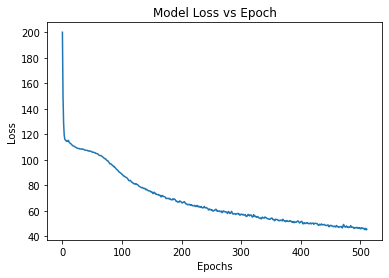

AttributeError: 'BatchNormFlow' object has no attribute 'inverse'

In [127]:
base_mu, base_cov = torch.zeros(90), torch.eye(90)
base_dist = MultivariateNormal(base_mu.to(device), base_cov.to(device))
#3 Layer R_NVP
model = stacked_NVP(d, k, hidden=512, n=30)
optim = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
N=10000
X=torch.Tensor(StandardScaler().fit_transform(jets[-1][:N])).float()

dataloader = DataLoader(X[:N], batch_size=int(N/10), shuffle=True)

epochs = 512

# training loop
losses = train(dataloader,model,  epochs, optim, scheduler)
view(X[:N],model, losses)

tensor(67.6774, device='cuda:0', grad_fn=<MaxBackward1>)


<IPython.core.display.Math object>

<IPython.core.display.Math object>

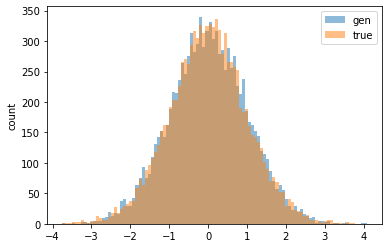

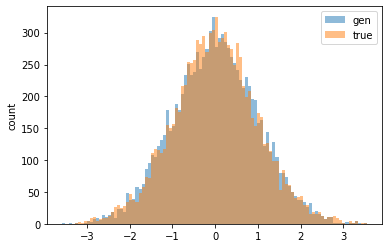

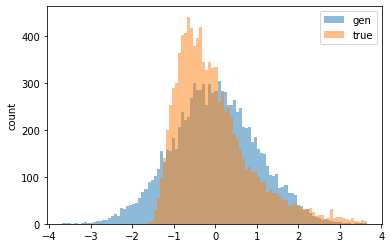

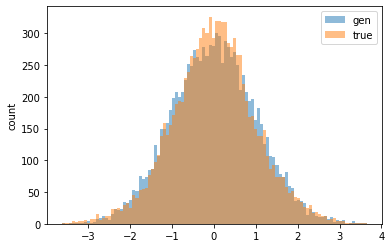

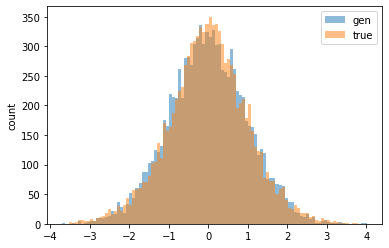

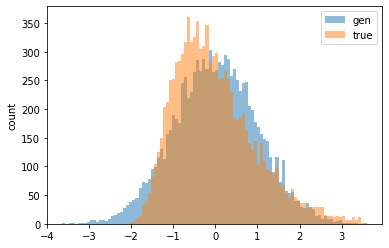

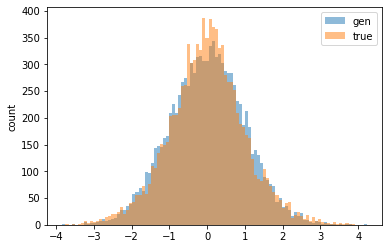

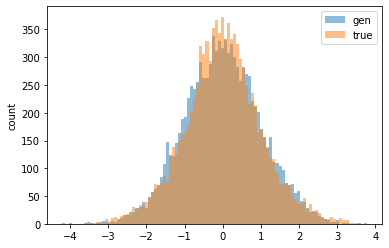

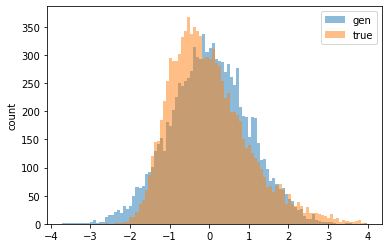

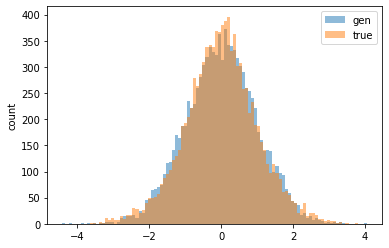

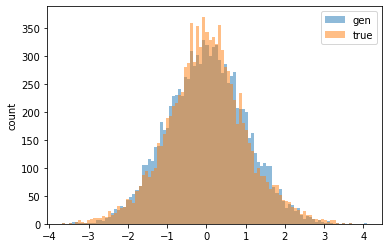

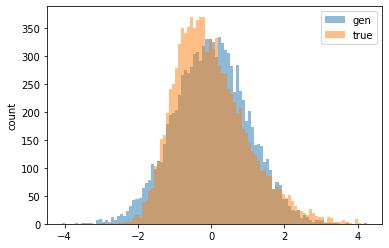

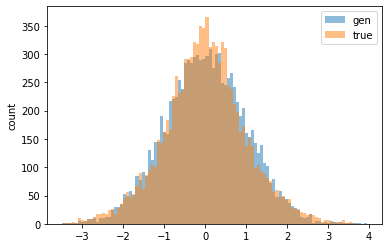

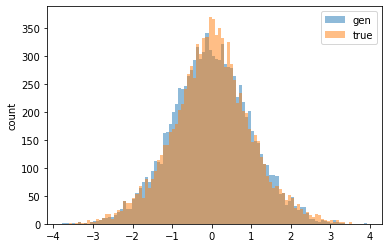

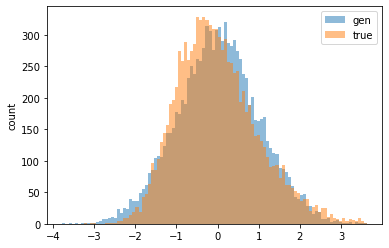

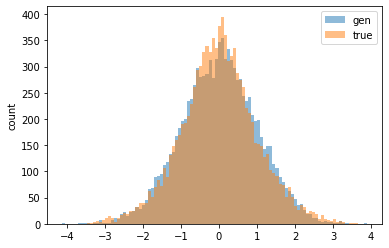

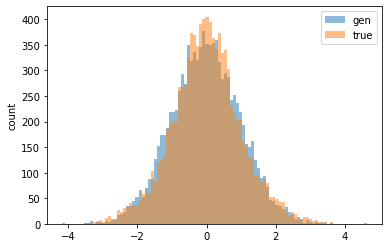

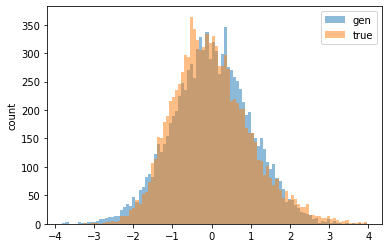

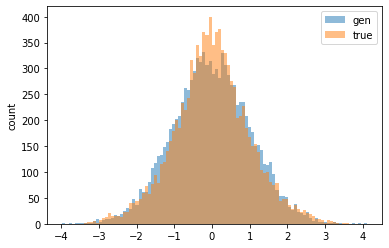

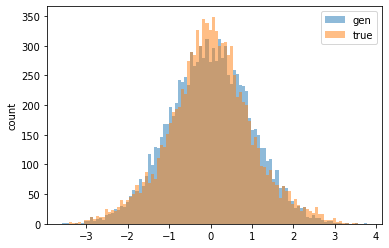

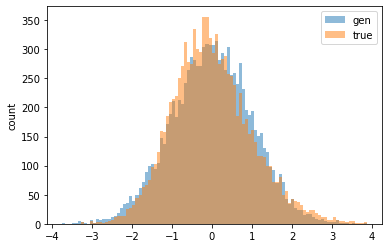

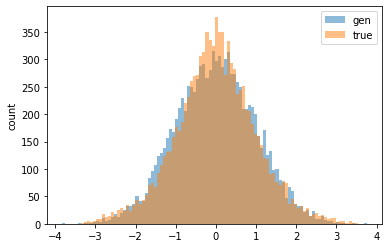

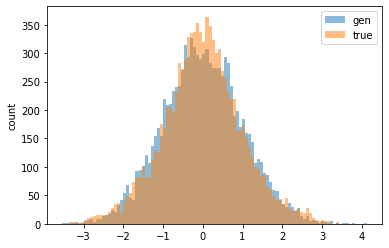

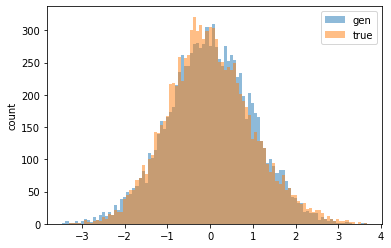

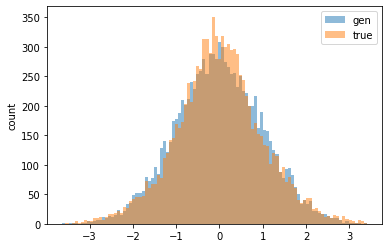

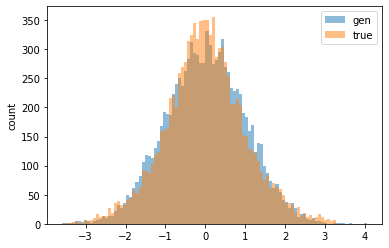

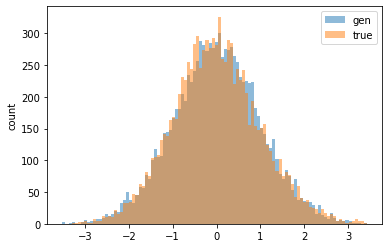

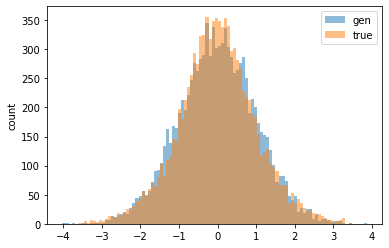

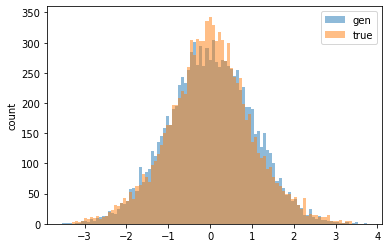

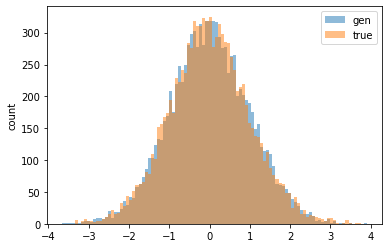

In [106]:
from IPython.display import display, Math
def chi(x_raw,y_raw,bins_count=30):
    
    chi=0
    for i in range(int(np.shape(x_raw)[1]/3)):
        x,bins=np.histogramdd(x_raw[:,i*3:(i+1)*3],bins_count,normed=True)
        y,_=np.histogramdd(y_raw[:,i*3:(i+1)*3],bins,normed=True)
        chi+=np.sum((x-y)**2/np.maximum(x+y,np.ones_like(x)))
    return chi
N=10000
gen=model(torch.randn([N,90]).to(device))[0].cpu().detach().numpy()
true=StandardScaler().fit_transform(jets[-1][:N])
true_sample=true[np.random.choice(1000)]
w1=np.round(jetnet.evaluation.w1p(gen[:N].reshape((len(gen[:N]),30,3)),true[:N].reshape((len(true[:N]),30,3)),num_batches=20),3)
#w1=np.round(jetnet.evaluation.w1p(gen_e[:N].reshape((len(gen_e[:N]),30,3)),true[:N].reshape((len(true[:N]),30,3)),num_batches=20),3)
display(Math(" W_1: {} \pm {}".format(w1[0],w1[1])))
display(Math(r'\chi^2 : {}'.format(np.round(chi(gen[:N],true[:N]),4))))
#display(Math(r'ensemble \chi^2 : {}'.format(np.round(chi(gen_e[:N],true[:N]),4))))

for col in range(30):
    plt.figure()
    n,bins,_=plt.hist(gen[:,col],label='gen',alpha=0.5,bins=100)
    #plt.hist(gen_e[:,col],label='gen_e',alpha=0.5,bins=bins)
    plt.hist(true[:,col],label='true',alpha=0.5,bins=bins)
    plt.ylabel('count')
    plt.legend()
    plt.show() 


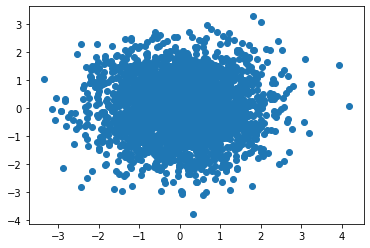

Epoch 1 loss: 129.87989807128906
Epoch 101 loss: 107.4286880493164


KeyboardInterrupt: 

In [114]:

#Single Layer R_NVP
model = R_NVP(d, k, hidden=512).to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.99999)
n_samples = 512

# training loop
losses = train(dataloader,model, 1000, n_samples, optim, scheduler)
view(X[:1000],model, losses)




Epoch 1 loss: 116.89531707763672


ValueError: Expected value argument (Tensor of shape (1000, 90)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([90]), covariance_matrix: torch.Size([90, 90])), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<CatBackward0>)

In [100]:


#5 Layer R_NVP
model = stacked_NVP(d, k, hidden=512, n=90)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, 0.999)
dataloader = DataLoader(X[:10000], batch_size=1000, shuffle=True)

n_samples = 512

# training loop
losses = train(dataloader,model, 1000, n_samples, optim, scheduler)
view(X[:1000], model, losses)



 

ValueError: Expected value argument (Tensor of shape (1000, 90)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([90]), covariance_matrix: torch.Size([90, 90])), but found invalid values:
tensor([[    nan,     nan,     nan,  ...,  1.2431, -1.7311,  0.4514],
        [    nan,     nan,     nan,  ...,  1.4287,  0.8299,  0.2505],
        [    nan,     nan,     nan,  ...,  0.0388, -0.4629, -0.1123],
        ...,
        [    nan,     nan,     nan,  ..., -1.3179, -1.7303, -0.0615],
        [    nan,     nan,     nan,  ..., -1.2421,  1.2642, -0.8625],
        [    nan,     nan,     nan,  ..., -1.6494, -0.3312,  0.7613]],
       device='cuda:0', grad_fn=<CatBackward0>)

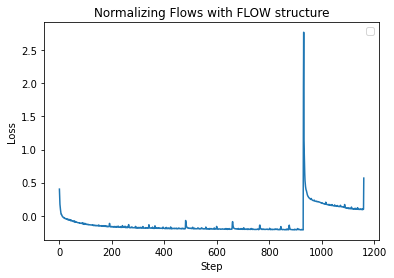

In [36]:


plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
# plt.ylim(-3,2)

plt.legend()
plt.title('Normalizing Flows with FLOW structure')
plt.show()

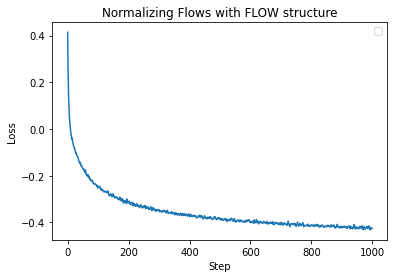

In [21]:
from IPython.display import display, Math
def chi(x_raw,y_raw,bins_count=30):
    
    chi=0
    for i in range(int(np.shape(x_raw)[1]/3)):
        x,bins=np.histogramdd(x_raw[:,i*3:(i+1)*3],bins_count,normed=True)
        y,_=np.histogramdd(y_raw[:,i*3:(i+1)*3],bins,normed=True)
        chi+=np.sum((x-y)**2/np.maximum(x+y,np.ones_like(x)))
    return chi
N=100000
inn=best_model.to('cpu')
gen=inn(torch.randn([N,90]),rev=True)[0].detach().numpy()
true=StandardScaler().fit_transform(jets[-1][:N])
true_sample=true[np.random.choice(N)]
w1=np.round(jetnet.evaluation.w1p(gen[:N].reshape((len(gen[:N]),30,3)),true[:N].reshape((len(true[:N]),30,3)),num_batches=20),3)
#w1=np.round(jetnet.evaluation.w1p(gen_e[:N].reshape((len(gen_e[:N]),30,3)),true[:N].reshape((len(true[:N]),30,3)),num_batches=20),3)
display(Math(" W_1: {} \pm {}".format(w1[0],w1[1])))
display(Math(r'\chi^2 : {}'.format(np.round(chi(gen[:N],true[:N]),4))))
#display(Math(r'ensemble \chi^2 : {}'.format(np.round(chi(gen_e[:N],true[:N]),4))))

for col in range(3):
    plt.figure()
    n,bins,_=plt.hist(gen[:,col],label='gen',alpha=0.5,bins=100)
    #plt.hist(gen_e[:,col],label='gen_e',alpha=0.5,bins=bins)
    plt.hist(true[:,col],label='true',alpha=0.5,bins=bins)
    plt.ylabel('count')
    plt.legend()
    plt.show() 

<IPython.core.display.Math object>

<IPython.core.display.Math object>

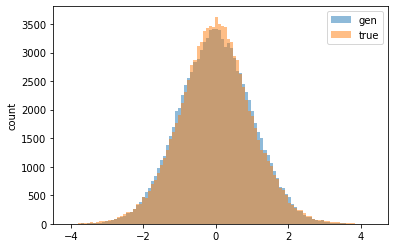

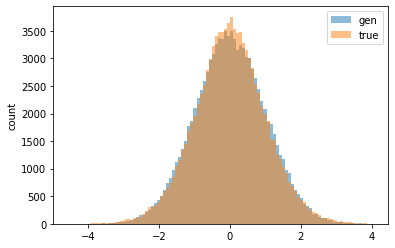

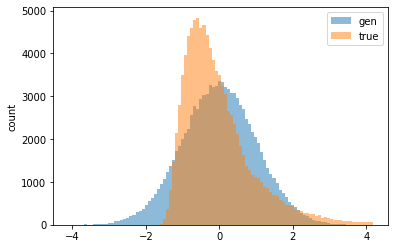

In [57]:
from IPython.display import display, Math
def chi(x_raw,y_raw,bins_count=30):
    
    chi=0
    for i in range(int(np.shape(x_raw)[1]/3)):
        x,bins=np.histogramdd(x_raw[:,i*3:(i+1)*3],bins_count,normed=True)
        y,_=np.histogramdd(y_raw[:,i*3:(i+1)*3],bins,normed=True)
        chi+=np.sum((x-y)**2/np.maximum(x+y,np.ones_like(x)))
    return chi
N=100000
gen=model(torch.randn([N,90]).to(device),)[0].cpu().detach().numpy()
true=jets[-1][:N]
true_sample=true[np.random.choice(1000)]
w1=np.round(jetnet.evaluation.w1p(gen[:N].reshape((len(gen[:N]),30,3)),true[:N].reshape((len(true[:N]),30,3)),num_batches=20),3)
#w1=np.round(jetnet.evaluation.w1p(gen_e[:N].reshape((len(gen_e[:N]),30,3)),true[:N].reshape((len(true[:N]),30,3)),num_batches=20),3)
display(Math(" W_1: {} \pm {}".format(w1[0],w1[1])))
display(Math(r'\chi^2 : {}'.format(np.round(chi(gen[:N],true[:N]),4))))
#display(Math(r'ensemble \chi^2 : {}'.format(np.round(chi(gen_e[:N],true[:N]),4))))

for col in range(3):
    plt.figure()
    n,bins,_=plt.hist(gen[:,col],label='gen',alpha=0.5,bins=100)
    #plt.hist(gen_e[:,col],label='gen_e',alpha=0.5,bins=bins)
    plt.hist(true[:,col],label='true',alpha=0.5,bins=bins)
    plt.ylabel('count')
    plt.legend()
    plt.show() 


In [31]:


plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
# plt.ylim(-3,2)

plt.legend()
plt.title('Normalizing Flows with FLOW structure')
plt.show()
x=jets[-1]
permuted_sample=np.zeros_like(x)
for j in range(np.shape(x)[1]):
    permuted_sample[:,j]+=x[np.random.permutation(len(x)),j]
z, log_jac_det = inn(torch.Tensor(x).to(device))
z_perm, log_jac_det_perm = inn(torch.Tensor(permuted_sample).to(device))
# calculate the negative log-likelihood of the model with a standard normal prior
loss = 0.5*torch.sum(z**2, 1) - log_jac_det
loss_perm = 0.5*torch.sum(z_perm**2, 1) - log_jac_det_perm
print("Original: ", loss.mean().cpu().detach().numpy())
print("permuted: ", loss_perm.mean().cpu().detach().numpy())

Original:  536.9477
permuted:  203414.47


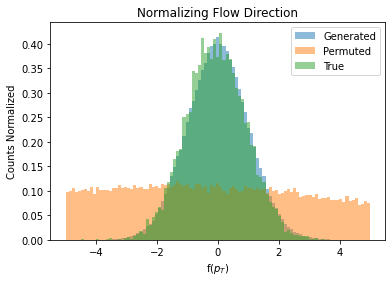

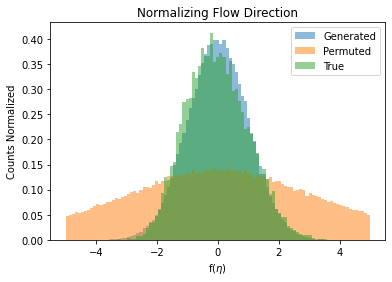

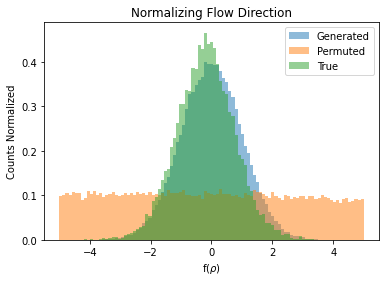

In [33]:


plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('Loss')
# plt.ylim(-3,2)

plt.legend()
plt.title('Normalizing Flows with FLOW structure')
plt.show()
x=jets[-1]
permuted_sample=np.zeros_like(x)
for j in range(np.shape(x)[1]):
    permuted_sample[:,j]+=x[np.random.permutation(len(x)),j]
z, log_jac_det = inn(torch.Tensor(x).to(device))
z_perm, log_jac_det_perm = inn(torch.Tensor(permuted_sample).to(device))
# calculate the negative log-likelihood of the model with a standard normal prior
loss = 0.5*torch.sum(z**2, 1) - log_jac_det
loss_perm = 0.5*torch.sum(z_perm**2, 1) - log_jac_det_perm
print("Original: ", loss.mean().cpu().detach().numpy())
print("permuted: ", loss_perm.mean().cpu().detach().numpy())
gen_inv=inn(inn(torch.randn([100000,90]).to(device),rev=True)[0])[0].cpu().detach().numpy()
gen_inv=gen_inv.reshape((len(gen_inv),30,3))

true_inv=inn.cpu()(X)[0].cpu().detach().numpy()
variables=[r'f($p_T$)',r'f($\eta$)',r'f($\rho$)']
for col in range(3):
    plt.figure()
    plt.title('Normalizing Flow Direction')
    bins=np.linspace(-5,5,100)
    plt.hist(gen_inv[:,0,col],label='Generated',alpha=0.5,bins=bins,density=1)
    plt.hist(z_perm[:,col].cpu().detach().numpy(),label='Permuted',alpha=0.5,bins=bins,density=1)
    plt.hist(true_inv[:,col],label='True',alpha=0.5,bins=bins,density=1)
    plt.ylabel('Counts Normalized')
    plt.xlabel(variables[col])
    plt.legend()
    plt.show()



In [35]:

def subnet(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 256), nn.ReLU(),
                         nn.Linear(256, dims_out))


in1 = Ff.InputNode(3, name='Input 1')
perm = Ff.Node(in1, Fm.PermuteRandom, {}, name='Permutation')
actnorm = Ff.Node(perm, Fm.ActNorm, {}, name='ActNorm')
in2 = Ff.InputNode()
cond1= Ff.ConditionNode(3)
cond2=Ff.ConditionNode((9))
cond3=Ff.ConditionNode((18))
cond4=Ff.ConditionNode()
gauss = Ff.Node(actnorm, Fm.GaussianMixtureModel,{},[cond1,cond2.Reshape(),cond3,cond4], name='gauss Coupling')

output1 = Ff.OutputNode(gauss, name='Output 1')
# output2 = Ff.OutputNode(concat2, name='Output 2')

example_INN = Ff.GraphINN([in1,cond1,cond2,cond3,cond4,perm,actnorm,gauss,output1])
c1=subnet(3,2)
c2=subnet(3,4).Reshape(2,6)
c3=subnet(3,).Reshape(2,9)
z1,log=example_INN.forward([x1],[c1,c2,c3,None])

        # Construct upper triangular Cholesky factors U of all precision matrices

        # Diagonal entries must be positive
        #U[self.mask_diagonal.expand(batch_size,n_components,-1,-1)] = U_entries[:,:,:self.x_dims].exp().reshape(-1)

        # Indices of chosen mixture components, if provided

AttributeError: 'Sequential' object has no attribute 'Reshape'

In [34]:
actnorm

Node 'ActNorm'